# Master Strategy (Long-Term + Short-Term) vs Benchmarks

### **Overview**
This notebook implements and backtests a combined trading strategy that allocates capital between:
- **Long-term strategy (85%)**: Rebalanced quarterly (every 66 trading days)
- **Short-term strategy (15%)**: Rebalanced weekly

### **Strategy Components**
- **Long-term**: Static buy-and-hold positions based on fundamental analysis
- **Short-term**: Technical analysis using SMA/EMA crossover signals
- **Benchmark**: Comparative analysis against market indices

### **Key Features**
- 80/20 train-test split for robust evaluation
- Transaction cost analysis
- Risk-adjusted performance metrics (Sharpe ratio, Sortino ratio)
- Comprehensive visualization and reporting

### **Step 1: Setup and Configuration** 

In [1]:
# Import libraries
from py.utils import load_and_filter_data
import glob, os, pandas as pd, numpy as np, matplotlib.pyplot as plt, bt
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Configuration
end_date = (datetime.today() - BDay(1)).to_pydatetime()
start_date = end_date - timedelta(days=10*365)
transaction_cost = 0.001  # 0.1% transaction cost

print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} ({(end_date - start_date).days/365:.1f} years)")

Analysis Period: 2015-06-12 to 2025-06-09 (10.0 years)


### **Step 2: Data Loading and Preparation**
Loading portfolio compositions, market data, and risk-free rates from pre-generated Excel files.

In [2]:
# Load portfolio and market data
output_file = max(glob.glob('portfolios/portfolio-*.xlsx'), key=os.path.getmtime)
sheets = ['long_term', 'short_term', 'benchmark_long_term', 'benchmark_short_term', 'daily_quotes']
long_term_df, short_term_df, bench_lt_df, bench_st_df, data = [pd.read_excel(output_file, sheet_name=sheet, index_col=0 if sheet=='daily_quotes' else None, parse_dates=True if sheet=='daily_quotes' else False) for sheet in sheets]

# Load risk-free rate
risk_free_rate = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date).iloc[-1, 0] / 100

# Portfolio composition
combined_df = pd.concat([long_term_df, short_term_df], ignore_index=True)
tickers = combined_df['Ticker'].unique()

print(f"Portfolio: {len(tickers)} assets | Risk-free rate: {risk_free_rate:.3%}")
display(combined_df[['Ticker', 'Strategy', 'Weight']].fillna(''))

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Portfolio: 7 assets | Risk-free rate: 4.240%


,Ticker,Strategy,Weight
0,MMC,Markowitz,0.318087
1,AMAT,Markowitz,0.228911
2,TMUS,Markowitz,0.223672
3,MRK,Markowitz,0.145330
4,APO,Markowitz,0.084000
5,MSFT,SMA_Cross_Signal,0.500000
6,NOC,SMA_Cross_Signal,0.500000


### **Step 3: Train-Test Split**
Splitting data into 80% training and 20% testing periods to evaluate out-of-sample performance.

In [3]:
# Split data
train_size = int(0.8 * len(data))
training_set, test_set = data.iloc[:train_size], data.iloc[train_size:]

print(f"Training: {len(training_set)} days ({training_set.index[0]} to {training_set.index[-1]})")
print(f"Testing: {len(test_set)} days ({test_set.index[0]} to {test_set.index[-1]})")

Training: 2009 days (2015-06-10 00:00:00 to 2023-06-01 00:00:00)
Testing: 503 days (2023-06-02 00:00:00 to 2025-06-04 00:00:00)


### **Step 4: Strategy Construction**
Building the master strategy with proper weight allocations and rebalancing frequencies.

#### Master Strategy

In [4]:
# Extract weights and benchmarks
long_weights = dict(zip(long_term_df['Ticker'], long_term_df['Weight']))
short_weights = dict(zip(short_term_df['Ticker'], short_term_df['Weight']))
weights_df = combined_df[['Ticker', 'Weight']]
weights = dict(zip(weights_df['Ticker'], weights_df['Weight']))
print(f"Long-Term Pf Weights: {long_weights}")
print(f"Short-Term Pf Weights: {short_weights}")

# Master Strategy
master_strategy = bt.Strategy('Master Strategy (No Costs)', 
    [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**{'Long Term Strategy': 0.85, 'Short Term Strategy': 0.15}), bt.algos.Rebalance()],
    children=[
        bt.Strategy('Long Term Strategy', [bt.algos.RunEveryNPeriods(66, offset=66), bt.algos.SelectAll(), bt.algos.WeighSpecified(**long_weights), bt.algos.Rebalance()]),
        bt.Strategy('Short Term Strategy', [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**short_weights), bt.algos.Rebalance()])
    ])

master_strategy = bt.Backtest(master_strategy, test_set)

Long-Term Pf Weights: {'MMC': 0.3180873008417999, 'AMAT': 0.2289105824374544, 'TMUS': 0.2236721160100146, 'MRK': 0.1453300807748326, 'APO': 0.08399991993589846}
Short-Term Pf Weights: {'MSFT': 0.5, 'NOC': 0.5}


#### Benchmark Strategy

In [5]:
# Extract benchmark tickers
long_term_benchmarks = bench_lt_df['Benchmark'].tolist()
short_term_benchmarks = bench_st_df['Benchmark'].tolist()
all_benchmarks = list(set(long_term_benchmarks + short_term_benchmarks))
print(f"Strategies created | Benchmarks: {all_benchmarks}")

# Create Benchmark Strategies
# Helper function to create benchmark strategy
def create_benchmark_strategy(name, benchmarks, rebalance_algo):
    available = list(set([b for b in benchmarks if b in test_set.columns]))
    if not available:
        return None
    
    weights = {b: 1.0/len(available) for b in available}
    strategy = bt.Strategy(name, [rebalance_algo, bt.algos.SelectAll(), bt.algos.WeighSpecified(**weights), bt.algos.Rebalance()])
    print(f"{name} weights: {weights}")
    return bt.Backtest(strategy, test_set[available])

# Create individual benchmark strategies
lt_benchmark = create_benchmark_strategy('Long Term Benchmark', long_term_benchmarks, bt.algos.RunEveryNPeriods(66, offset=66))
st_benchmark = create_benchmark_strategy('Short Term Benchmark', short_term_benchmarks, bt.algos.RunWeekly())

# Create combined benchmark strategy
if lt_benchmark and st_benchmark:
    combined_benchmark_strategy = bt.Strategy('Benchmarks (Combined)', [
        bt.algos.RunWeekly(), bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**{'Long Term Benchmark': 0.85, 'Short Term Benchmark': 0.15}),
        bt.algos.Rebalance()
    ], children=[lt_benchmark.strategy, st_benchmark.strategy])
    
    benchmark_strategy = bt.Backtest(combined_benchmark_strategy, test_set)
    print("Combined Benchmarks Strategy: Long-Term = 85% (Quarterly) | Short-Term = 15% (Weekly)")
else:
    raise ValueError("Could not create benchmark strategies")

# Use the combined benchmark strategy for comparison
benchmark_strategy = bt.Backtest(combined_benchmark_strategy, test_set)

Strategies created | Benchmarks: ['YYY', 'DSI']
Long Term Benchmark weights: {'YYY': 1.0}
Short Term Benchmark weights: {'DSI': 1.0}
Combined Benchmarks Strategy: Long-Term = 85% (Quarterly) | Short-Term = 15% (Weekly)


### **Step 5: Transaction Cost Analysis**
Implementing transaction costs to assess the real-world impact on strategy performance.

In [6]:
# Transaction cost algorithm
class TransactionCostAlgo(bt.Algo):
    def __init__(self, cost=0.001):
        super().__init__()
        self.cost = cost
    
    def __call__(self, target):
        if 'weights' not in target.temp: return True
        
        new_weights = pd.Series(target.temp['weights'])
        prev_weights = target.get_data('weights_prev') if 'weights_prev' in target._original_data else pd.Series(0, index=new_weights.index)
        
        turnover = (new_weights - prev_weights).abs().sum()
        target.temp['weights'] = new_weights * (1 - turnover * self.cost)
        target.temp['weights_prev'] = target.temp['weights'].copy()
        return True

In [7]:
# Transaction cost for the master strategy
transaction_cost = 0.01 # 1% transaction cost for the master strategy

# Strategy with transaction costs
master_with_costs = bt.Strategy('Master Strategy (With Costs)',
    [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**{'Long Term Strategy': 0.85, 'Short Term Strategy': 0.15}), TransactionCostAlgo(transaction_cost), bt.algos.Rebalance()],
    children=[
        bt.Strategy('Long Term Strategy', [bt.algos.RunEveryNPeriods(66, offset=66), bt.algos.SelectAll(), bt.algos.WeighSpecified(**long_weights), TransactionCostAlgo(transaction_cost), bt.algos.Rebalance()]),
        bt.Strategy('Short Term Strategy', [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**short_weights), TransactionCostAlgo(transaction_cost), bt.algos.Rebalance()])
    ])

master_strategy_with_costs = bt.Backtest(master_with_costs, test_set)

### **Step 6: Backtest Execution + Results Analysis and Visualization**
Running comprehensive backtests comparing strategy performance with and without transaction costs.

100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Stat                 Master Strategy (No Costs)    Master Strategy (With Costs)    Benchmarks (Combined)
-------------------  ----------------------------  ------------------------------  -----------------------
Start                2023-06-01                    2023-06-01                      2023-06-01
End                  2025-06-04                    2025-06-04                      2025-06-04
Risk-free rate       0.00%                         0.00%                           0.00%

Total Return         29.48%                        28.88%                          24.08%
Daily Sharpe         0.99                          0.99                            1.02
Daily Sortino        1.62                          1.62                            1.53
CAGR                 13.72%                        13.46%                          11.33%
Max Drawdown         -12.90%                       -12.65%                         -14.91%
Calmar Ratio         1.06                          1.06        

100%|██████████| 2/2 [00:00<00:00, 8674.88it/s]


<Axes: title={'center': 'Transaction Cost Impact: Master Strategy'}>

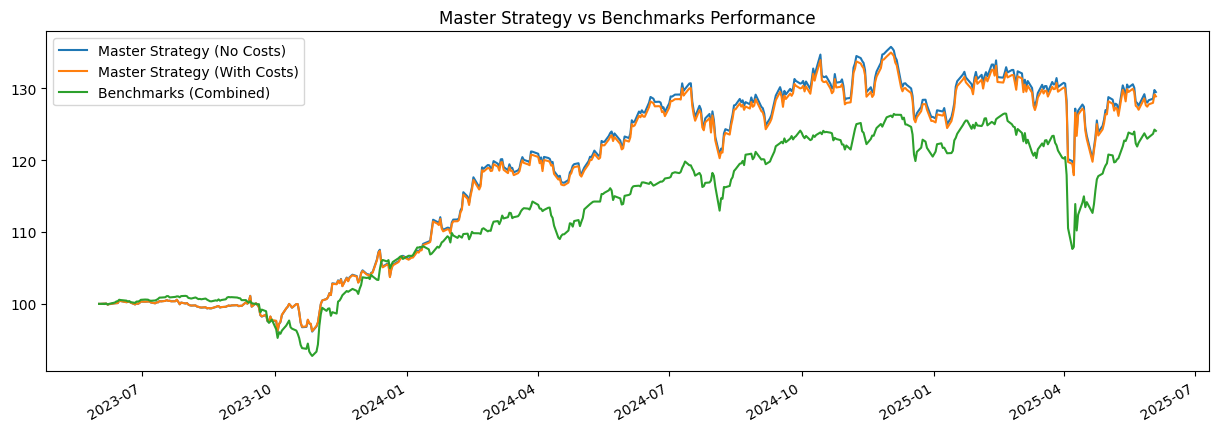

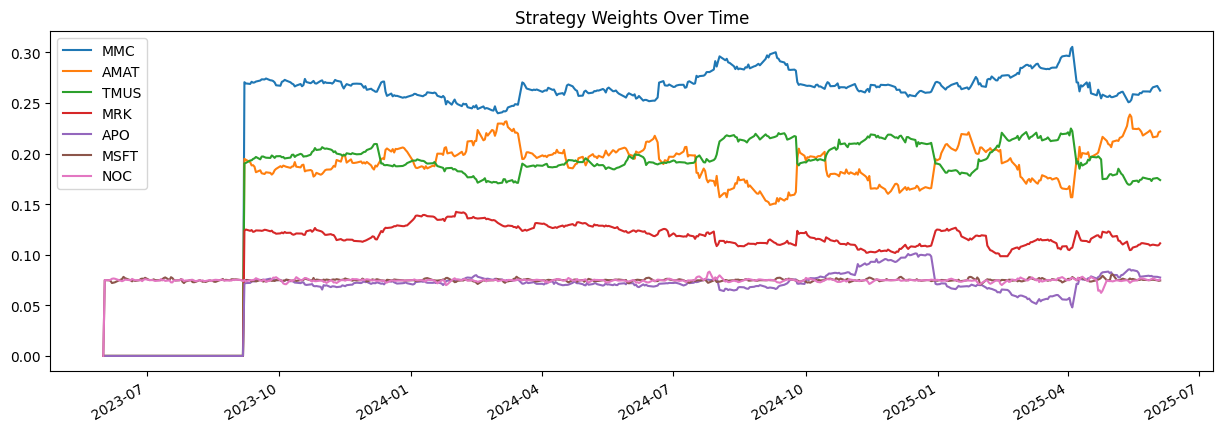

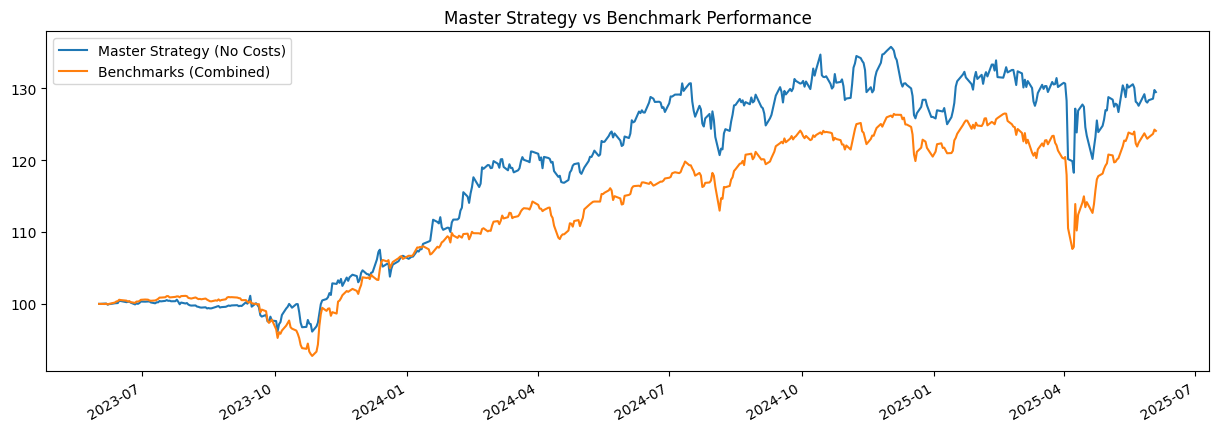

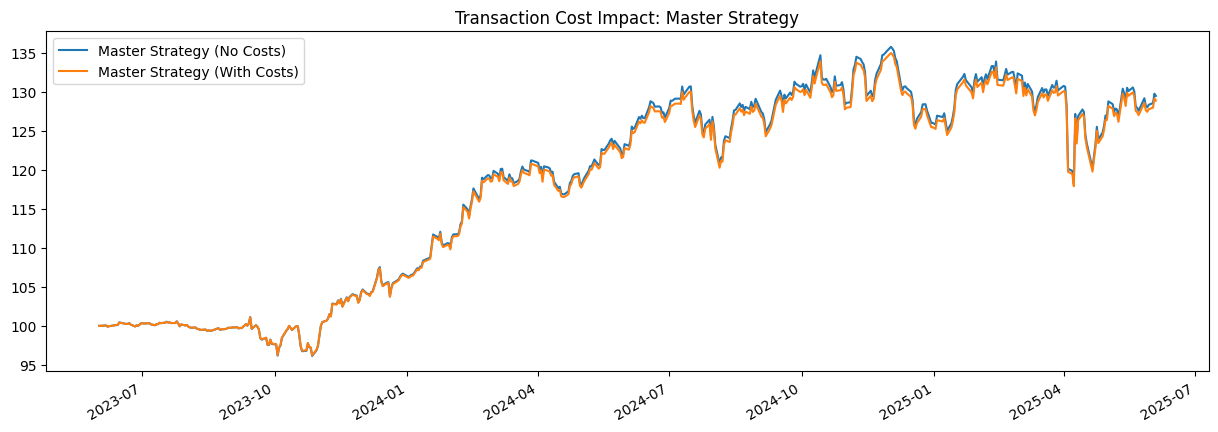

In [8]:
# Combine results and plot
res = bt.run(master_strategy, master_strategy_with_costs, benchmark_strategy)
res.display()
res.plot(title='Master Strategy vs Benchmarks Performance')
res.plot_security_weights(title='Strategy Weights Over Time')

# Plot just the Master Strategy and Benchmark for clarity
master_only = bt.run(master_strategy, benchmark_strategy)
master_only.set_riskfree_rate(risk_free_rate)
master_only.plot(title='Master Strategy vs Benchmark Performance')

# Transaction cost comparison separately
cost_comparison = bt.run(master_strategy, master_strategy_with_costs)
cost_comparison.set_riskfree_rate(risk_free_rate)
cost_comparison.plot(title='Transaction Cost Impact: Master Strategy')

## **Summary**

This backtest demonstrates the effectiveness of combining long-term and short-term strategies:

### **Key Insights:**
- **Risk Management**: Diversification across time horizons reduces portfolio volatility
- **Transaction Costs**: Real-world costs significantly impact short-term strategy performance
- **Benchmark Performance**: Strategy effectiveness vs. passive index investing

### **Strategy Allocation Rationale:**
- **85% Long-term**: Provides stability and captures long-term market trends
- **15% Short-term**: Adds tactical flexibility and potential alpha generation

### **Risk Considerations:**
- Market regime changes may affect strategy performance
- Transaction costs disproportionately impact high-frequency rebalancing
- Out-of-sample testing provides realistic performance expectations